In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ds = pd.read_csv('caras.csv')
ds.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,person_id
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.669422,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0


# 1. Inspección de los datos
El dataset caras.csv contiene 800 imágenes de 68 × 68 pixeles en escala de grises, junto con sus etiquetas de clase. Para realizar un análisis exploratorio de estos datos, se proponen los siguientes puntos:

## a) Graficar Imagenes
Implementar una función que pueda graficar un número arbitrario de imágenes del dataset. Mostrar un ejemplo de un gráfico con 15 imágenes seleccionadas de manera aleatoria.
Esta función va a ser necesaria a lo largo de todo el trabajo, por lo que se deberá ir adaptando de acuerdo a las necesidades que vayan surgiendo.

In [3]:
def plot_random_img(ds, n_img=15, rand_seed=None):
    """
    Selecciona n_img imágenes aleatorias del dataset y las muestra en una grilla. Por defecto, muestra 15 imágenes.
    """
    sample = ds.sample(n_img, random_state=rand_seed)
    cols = min(n_img, 5)
    rows = int(np.ceil(n_img / cols))
    fig, ax = plt.subplots(rows, cols, figsize=(2.5*cols, 2.5*rows))
    ax = np.atleast_2d(ax)

    idx = 0
    for i in range(rows):
        for j in range(cols):
            if idx < n_img:
                img = sample.iloc[idx, :-1].values.reshape(64, 64)
                ax[i, j].imshow(img, cmap='gray')
                ax[i, j].axis('off')
                ax[i, j].set_title(f"ID: {sample.iloc[idx]['person_id']}", fontsize=8)
                idx += 1
            else:
                ax[i, j].axis('off')

    plt.tight_layout()
    plt.show()

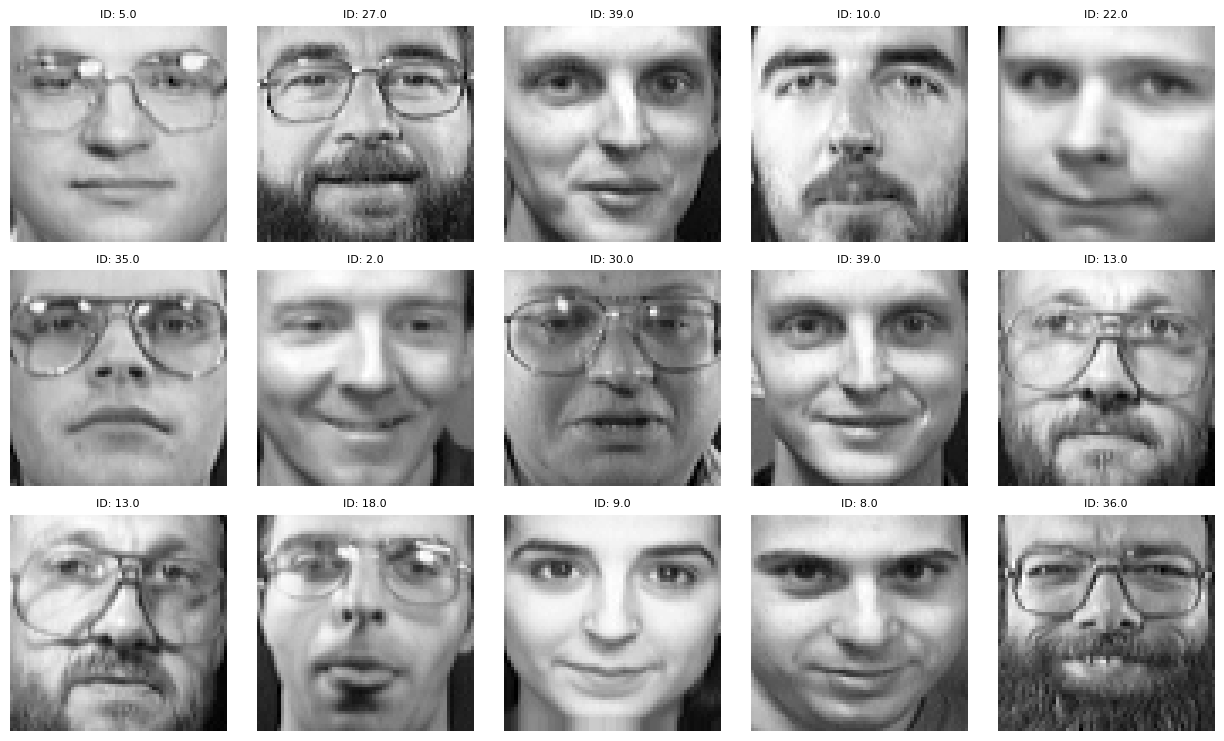

In [4]:
plot_random_img(ds, n_img=15, rand_seed=43)

## b) Analizar distribucion por clase
Realizar un analisis exploratorio enfocado en la distribución de clases en los datos.

In [5]:
def plot_distribution(ds, target_col='person_id'):
  ids = ds[target_col]
  counts = ids.value_counts().sort_index()
  classes = counts.index.to_numpy()
  values  = counts.values
  cmap = plt.get_cmap('tab20', len(classes))
  colors = [cmap(i) for i in range(len(classes))]

  plt.figure(figsize=(10,4))
  plt.bar(classes, values, color=colors, width=0.9)
  plt.xlabel('person_id')
  plt.ylabel('frecuencia')
  plt.xticks(classes)         # asegura ticks en cada clase
  plt.title('Distribución por clase')
  plt.tight_layout()
  plt.show()

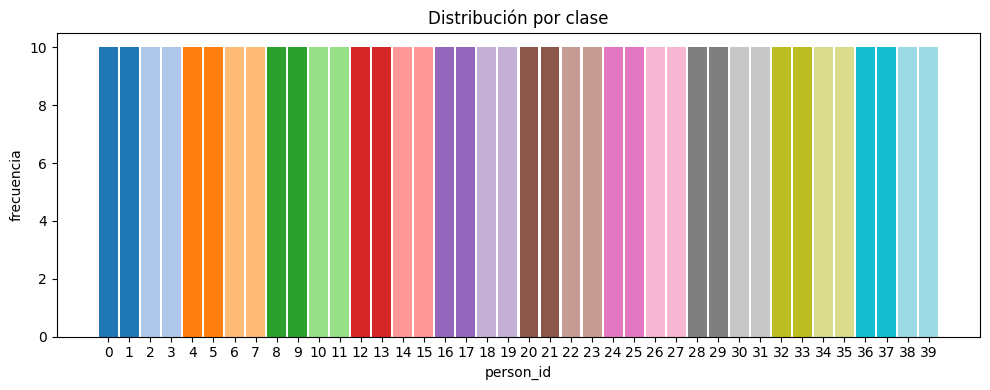

In [6]:
plot_distribution(ds)

 Para tener una mejor noción de la variabilidad de las muestras, graficar muestras agrupadas por clase, para al menos 5 clases.

In [7]:
def plot_by_class(ds, ids, num_img, rand_seed=None):
  """
    Recibe una lista de ids de personas y muestra 5 imágenes correspondientes a cada etiqueta id. Asume un minimo de 5 muestras por clase.
  """
  for id in ids:
    imgs = ds[ds['person_id'] == id].sample(num_img, random_state=rand_seed)
    cols = num_img
    rows = int(np.ceil(5 / cols))
    fig, ax = plt.subplots(rows, cols, figsize=(2.5*cols, 2.5*rows))
    ax = np.atleast_2d(ax)

    idx = 0
    for i in range(rows):
        for j in range(cols):
            if idx < num_img:
                img = imgs.iloc[idx, :-1].values.reshape(64, 64)
                ax[i, j].imshow(img, cmap='gray')
                ax[i, j].axis('off')
                ax[i, j].set_title(f"ID: {imgs.iloc[idx]['person_id']}", fontsize=8)
                idx += 1
            else:
                ax[i, j].axis('off')

    plt.tight_layout()
    plt.show()

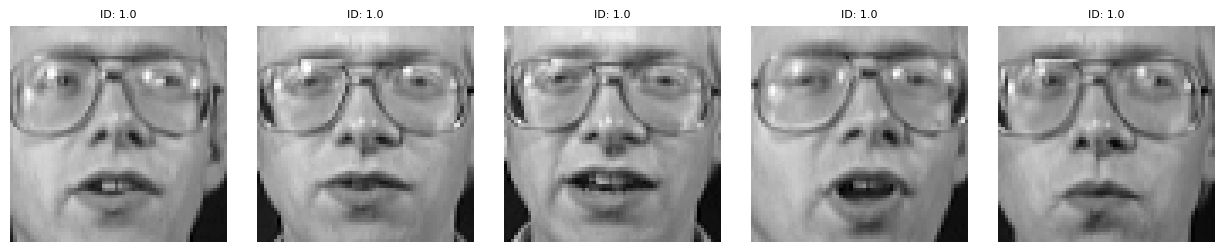

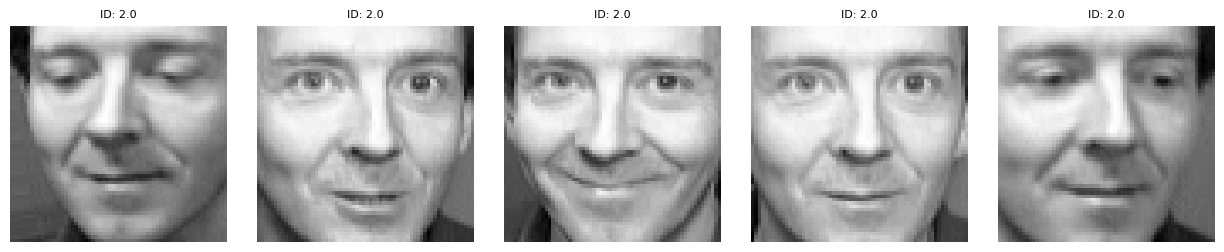

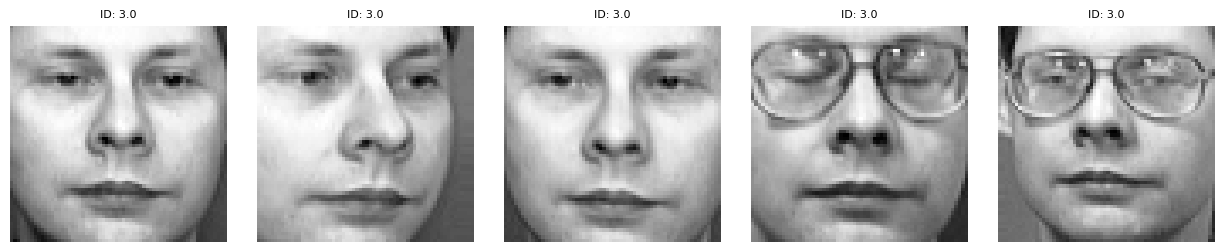

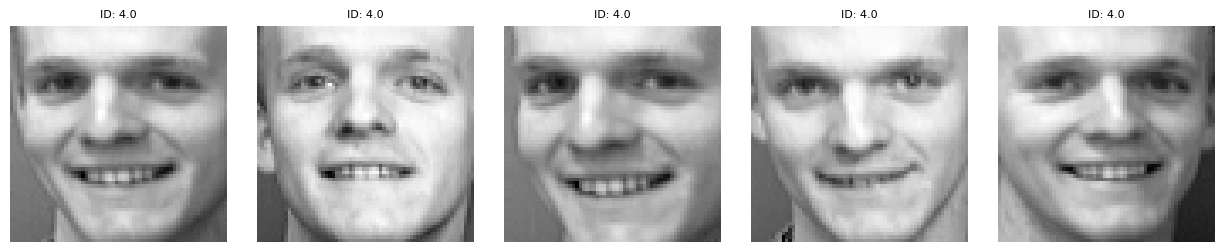

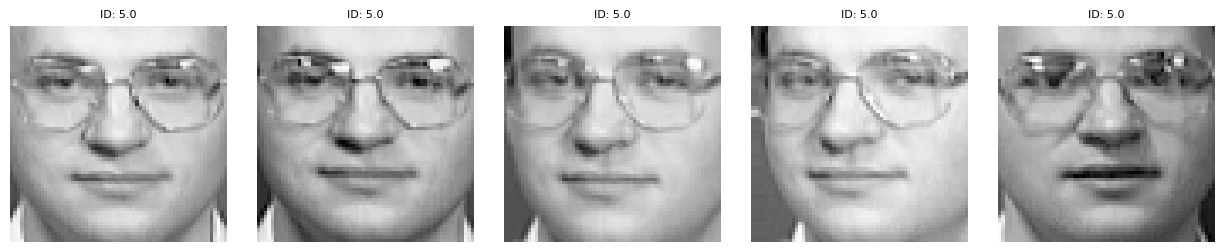

In [8]:
plot_by_class(ds, [1, 2, 3, 4, 5], 5, rand_seed=43)

## c) Split de datos
Realizar un split de datos estratificado para conformar un conjunto de entrenamiento y otro de evaluación, en donde los datos de evaluación sean el 20 % del total.

In [9]:
def stratified_split(df, label_col, test_size=0.2, rand_seed=None):
    """
    Divide el dataset en train/test manteniendo la proporción de clases.
    """
    np.random.seed(rand_seed)
    train_parts = []
    test_parts = []

    for cls, subset in df.groupby(label_col):
        n_test = int(len(subset) * test_size)
        shuffled = subset.sample(frac=1, random_state=rand_seed)
        test_parts.append(shuffled.iloc[:n_test])
        train_parts.append(shuffled.iloc[n_test:])

    df_train = pd.concat(train_parts).sample(frac=1, random_state=rand_seed).reset_index(drop=True)
    df_test  = pd.concat(test_parts).sample(frac=1, random_state=rand_seed).reset_index(drop=True)

    return df_train, df_test

In [19]:
train, val = stratified_split(ds, 'person_id', test_size=0.2, rand_seed=43)

y_train = train['person_id']
y_val = val['person_id']

x_train = train.drop(columns=['person_id'])
x_val = val.drop(columns=['person_id'])

chequeo balances

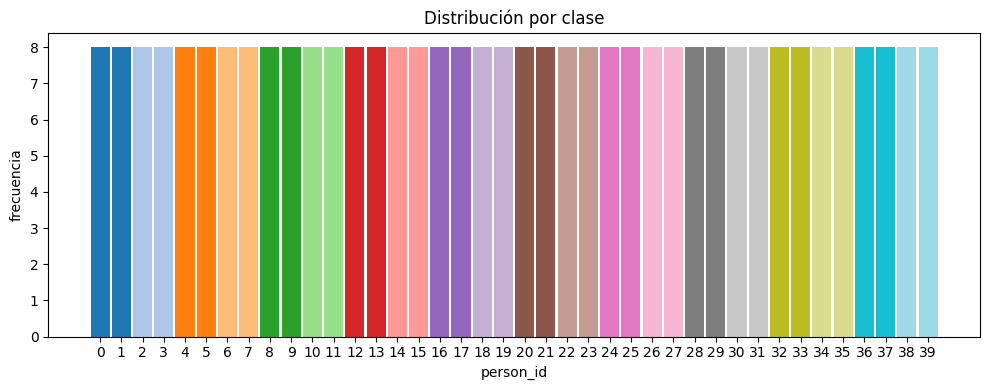

In [11]:
plot_distribution(train)

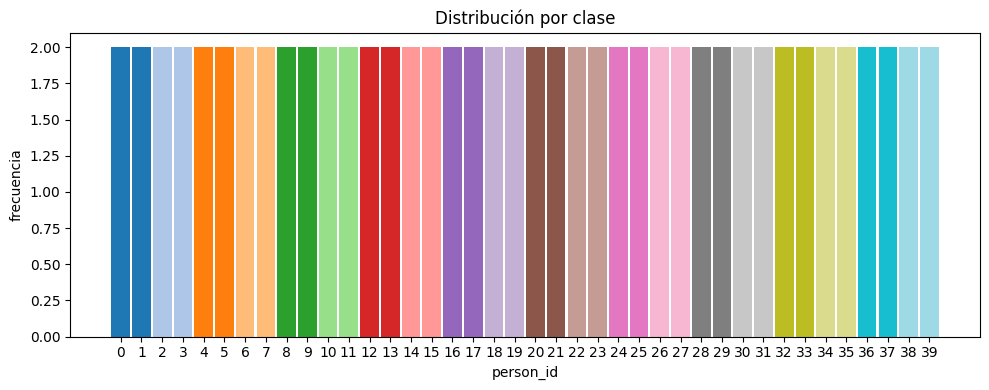

In [12]:
plot_distribution(val)

# 2. Reducción de dimensionalidad

## a) Estandarización y PCA
Implementar una función para estandarizar los datos, y otra para realizar Principal Component Analysis (PCA). Estandarizar y aplicar PCA sobre los datos de entrenamiento. Con la transformacion aprendida previamente reducir la dimensionalidad de los datos de evaluacion.

### Estandarización:

In [13]:
def standardize_per_image(df):
    """
    Estandariza cada imagen (fila) a media 0 y var 1 dentro de la misma imagen.
    """
    mu = df.mean(axis=1, keepdims=True)
    sigma = df.std(axis=1, keepdims=True)
    sigma[sigma == 0] = 1.0
    Xz = (df - mu) / sigma
    return Xz

In [15]:
standardize_per_image(x_train.to_numpy())

array([[-0.74185825, -0.6097326 , -0.82113367, ..., -1.77243822,
        -1.82528852, -1.71958799],
       [-1.35722247, -1.35722247, -2.50366643, ..., -0.41459077,
        -0.64387955, -0.72030912],
       [ 1.01473764,  1.11850748,  1.14444977, ..., -0.9309441 ,
        -0.87905934, -0.98282906],
       ...,
       [-1.34813995, -1.22523904, -1.12691846, ...,  0.24957016,
         1.08529555,  1.35567698],
       [-0.86429573, -0.80003605, -1.53902097, ..., -1.44263167,
        -0.57512777,  0.26024653],
       [-1.01788171, -0.54944057,  0.50455189, ..., -2.5871594 ,
        -2.61058145, -2.56373735]])

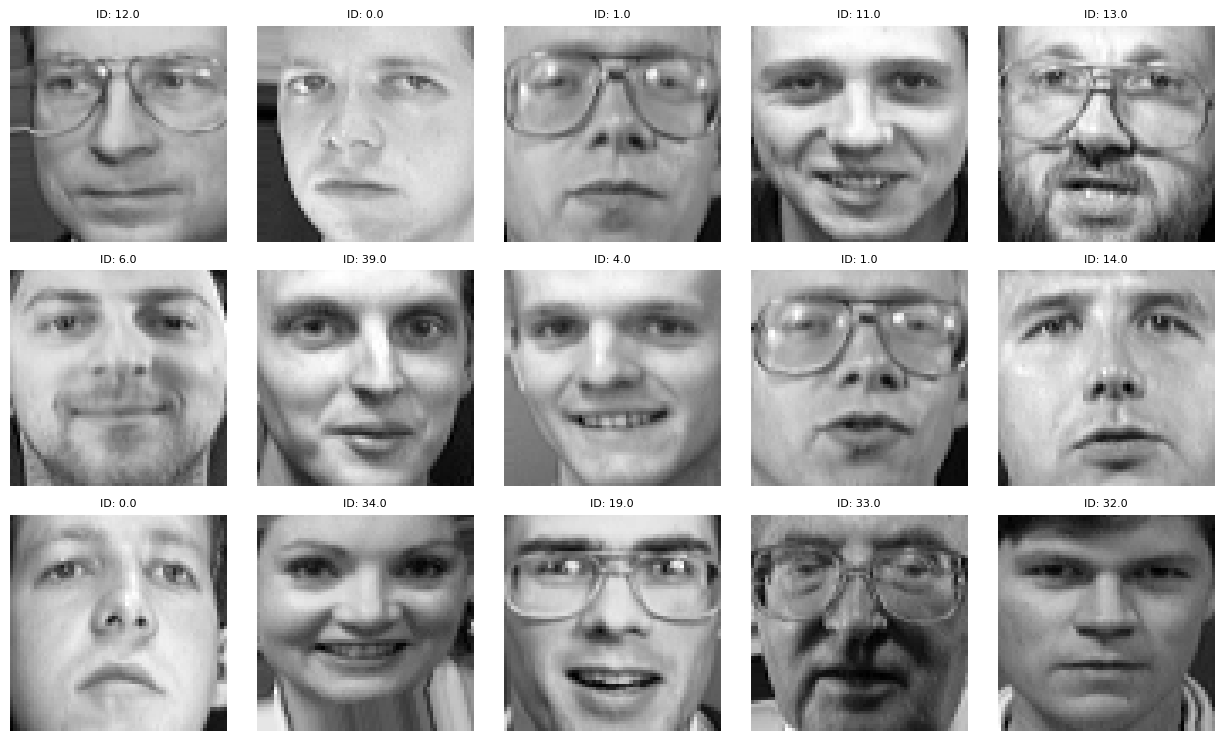

In [16]:
plot_random_img(train)

### PCA:

In [21]:
import numpy as np

class PCAFromScratch:
    def __init__(self, n_components, center=True, scale=False):
        self.n_components = n_components
        self.center = center
        self.scale = scale
        self.mean_ = None
        self.scale_ = None
        self.components_ = None
        self.singular_values_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None

    def fit(self, X_train):
        X = np.asarray(X_train, dtype=float)
        n, p = X.shape
        self.mean_ = X.mean(axis=0) if self.center else np.zeros(p)
        Xc = X - self.mean_
        if self.scale:
            self.scale_ = Xc.std(axis=0, ddof=1)
            self.scale_[self.scale_ == 0] = 1.0
            Xc = Xc / self.scale_
        else:
            self.scale_ = np.ones(p)

        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)   # Xc = U S V^T
        k = self.n_components
        self.components_ = Vt[:k]
        self.singular_values_ = S[:k]

        eigvals = (S**2) / (n - 1)
        self.explained_variance_ = eigvals[:k]
        self.explained_variance_ratio_ = eigvals[:k] / eigvals.sum()
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        Xc = (X - self.mean_) / self.scale_
        return Xc @ self.components_.T

    def fit_transform(self, X_train):
        return self.fit(X_train).transform(X_train)

    def inverse_transform(self, Z):
        Xc_rec = Z @ self.components_
        return Xc_rec * self.scale_ + self.mean_


In [18]:
def pca_fit_select_transform(X_train, X_test=None, threshold=0.90,
                             center=True, scale=False, plot=True, random_state=None):
    """
    Ajusta PCA en TRAIN con todos los componentes, grafica varianza explicada acumulada,
    elige k mínimo que alcanza >= threshold, y transforma TRAIN/TEST con esos k.

    Devuelve: dict con k, curva acumulada, pca_truncado, Z_train, Z_test (si se pasó).
    """
    X_train = np.asarray(X_train, dtype=float)
    if X_test is not None:
        X_test = np.asarray(X_test, dtype=float)

    # 1) PCA completo en TRAIN
    k_full = min(X_train.shape[0], X_train.shape[1])
    pca_full = PCAFromScratch(n_components=k_full, center=center, scale=scale)
    pca_full.fit(X_train)

    # 2) Varianza explicada acumulada y k*
    cum = np.cumsum(pca_full.explained_variance_ratio_)
    k_star = int(np.searchsorted(cum, threshold) + 1)

    # 3) Plot
    if plot:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(np.arange(1, len(cum)+1), cum, marker='o')
        ax.axhline(threshold, linestyle='--')
        ax.axvline(k_star, linestyle='--')
        ax.scatter([k_star], [cum[k_star-1]], s=60, zorder=3)
        ax.set_xlabel('Número de componentes')
        ax.set_ylabel('Varianza explicada acumulada')
        ax.set_ylim(0, 1.01)
        ax.set_title('Curva de varianza explicada')
        fig.tight_layout()
        plt.show()

    # 4) Construir un PCA truncado a k*
    pca_k = PCAFromScratch(n_components=k_star, center=center, scale=scale)
    pca_k.mean_  = pca_full.mean_
    pca_k.scale_ = pca_full.scale_
    pca_k.components_ = pca_full.components_[:k_star]
    pca_k.singular_values_ = pca_full.singular_values_[:k_star]
    pca_k.explained_variance_ = pca_full.explained_variance_[:k_star]
    pca_k.explained_variance_ratio_ = pca_full.explained_variance_ratio_[:k_star]

    # 5) Transformar TRAIN/TEST con k*
    Z_train = pca_k.transform(X_train)
    Z_test  = pca_k.transform(X_test) if X_test is not None else None

    return {
        "k": k_star,
        "cum_explained_variance": cum,
        "pca": pca_k,
        "Z_train": Z_train,
        "Z_test": Z_test
    }

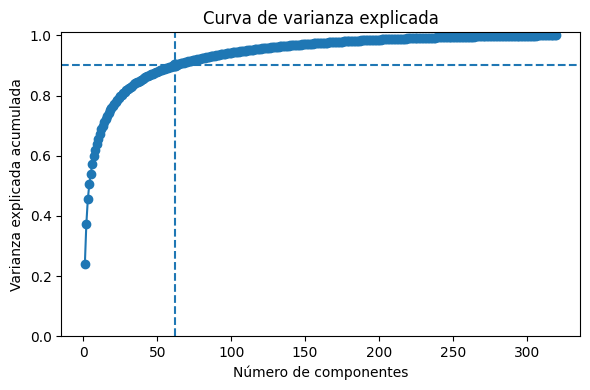

k elegido: 62


In [22]:
res = pca_fit_select_transform(x_train, x_val, threshold=0.90, center=True,
                               scale=False, plot=True)

print("k elegido:", res["k"])
Z_train, Z_test = res["Z_train"], res["Z_test"]
pca_90 = res["pca"]